In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 4.3 MB/s 


In [ ]:
!pip install keras

In [ ]:

import pandas as pd
import numpy as np
import cv2    
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from google.colab import drive
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
# from tensorflow.keras.optimizers import SGD
from sklearn.utils import class_weight, shuffle
import os
from tqdm.notebook import trange, tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix


plt.style.use('ggplot')

%matplotlib inline

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
drive.mount('/content/drive')
!unzip -n '/content/drive/MyDrive/DEEP_LEARNING/dataset_animals.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OI

Examinando los archivos

In [ ]:
#Getting foldernames from dataset
foldernames = os.listdir('raw-img')
main_path  = ('raw-img/')

#Creating Empty lists for categories and the files
categories = []
files = []
i = 0

#Going over all the folders and their categories in the foldernames
for k, folder in enumerate(foldernames):
    #Getting the filenames
    filenames = os.listdir(main_path + folder);
    for file in filenames:
        #Appending all the image files into one list
        files.append(main_path + folder + "/" + file)
        #Appending categories into one list
        categories.append(k)

#Defining a DataFrame to store data
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

#Taking 500 files of each category from the data into train_df
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

#Taking a peek at the data using head()
train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,raw-img/pecora/OIP-7kmU4irfs71YAM6QrPr8hwHaE7....,0
1,raw-img/pecora/OIP-kbaPLGJdGzIy9CaZDK10lwHaFi....,0
2,raw-img/pecora/OIP-esk-OqBxL-eQclesA3xh6AHaFL....,0
3,raw-img/pecora/e835b00d2afd093ed1584d05fb1d4e9...,0
4,raw-img/pecora/OIP-1kIBj0MnqHyk5zt3GoWJpwHaE7....,0
...,...,...
4995,raw-img/farfalla/OIP-679ZlqcCUPiH82QAKLPu-wHaE...,9
4996,raw-img/farfalla/ea37b20920f5033ed1584d05fb1d4...,9
4997,raw-img/farfalla/OIP-rVS4ZHHEtHlD8VTF33phYwAAA...,9
4998,raw-img/farfalla/OIP-Y-EO5dVtQ2oizcaGgU7XPgHaF...,9


Asignacion de los datos de entrenamiento

In [ ]:
#Assigning x and y to be the values and their target labels respectively
y = train_df['category']
x = train_df['filename']

#Shuffling the data
# x, y = shuffle(x, y, random_state=8)

Funciones para el procesado de imagen

In [ ]:
#Standard DataPreprocessing from OpenCV used for formatting the input to fit 
#the specifications of the input of the VGG-16 model

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    #Finding the centre of the image by calculating horizontal
    #and vertical distances
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
#tqdm is used for visualing the progress of the image preprocessing as a progress bar
with tqdm(total=len(train_df)) as pbar:
    #Going over all the filenames in train_df
    for i, file_path in enumerate(train_df.filename.values):
        #Read image using imread
        img = cv2.imread(file_path)
        
        #Converting colour channels of all pictures to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Centering all the images
        img = centering_image(cv2.resize(img, dsize=(256, 256)))

        #We have to shape the output to 224x224px because the VGG-16 model takes in input shape of 224x224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

  0%|          | 0/5000 [00:00<?, ?it/s]

Visualizacion de algunos datos del dataset

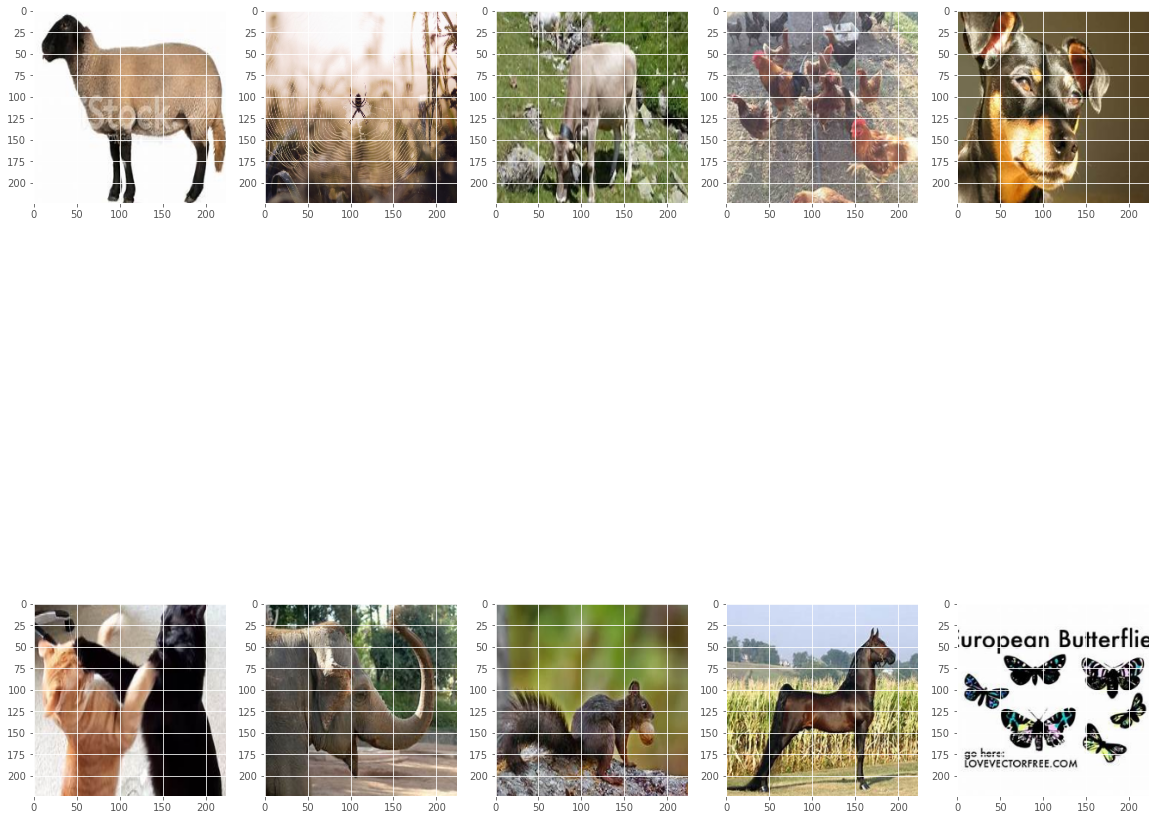

In [ ]:
#10 images one for each category
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

#Going over each category
for i in range(10):
    #Getting path for each category
    path = train_df[train_df.category == i].values[2]
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

Division de los datos en entrenamiento y test

In [ ]:
#Getting a list of the number of images used and a random index permutation from the data
#to randomly append images into x_shuffle along with their labels
data_num = len(y)
random_index = np.random.permutation(data_num)

#Empty lists to store shuffled data
x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

#Partitioning 20% of the dataset into test set
test_split_num = int(round(0.2*len(y)))
x_train = x[test_split_num:]
y_train = y[test_split_num:]
x_test = x[:test_split_num]
y_test = y[:test_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

#Converting categories into binary matrix of 0s and 1s where 1 represents the correct class
#and 0s in all other places
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Converting all pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Formatting all the pixel values to be in between 0 and 1
x_train /= 255
x_test /= 255

#Changing category labels from given language into english
img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


Definicion del modelo

In [ ]:
#Getting the base VGG-16 model
base_model = applications.InceptionV3(include_top=False, input_shape=(img_rows, img_cols, img_channel))

#Sequential model used for the task
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

#Defining the model
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activation_104 (Activation)    (None, 25, 25, 96)   0           ['batch_normalization_104[0][0]']
                                                                                                  
 activatio

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

Entrenamiento

In [ ]:
batch_size = 16
epochs = 10

#Data Augmentation
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

#Fitting the model
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    verbose = 1,
    validation_data=(x_test, y_test),
    # callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/10
250/250 [==============================] - 126s 505ms/step - loss: 0.2651 - accuracy: 0.4697 - val_loss: 0.2031 - val_accuracy: 0.7070
Epoch 2/10
250/250 [==============================] - 85s 340ms/step - loss: 0.1950 - accuracy: 0.6898 - val_loss: 0.1482 - val_accuracy: 0.8320
Epoch 3/10
250/250 [==============================] - 86s 342ms/step - loss: 0.1588 - accuracy: 0.7535 - val_loss: 0.1168 - val_accuracy: 0.8750
Epoch 4/10
250/250 [==============================] - 85s 340ms/step - loss: 0.1353 - accuracy: 0.7940 - val_loss: 0.0979 - val_accuracy: 0.8880
Epoch 5/10
250/250 [==============================] - 85s 340ms/step - loss: 0.1218 - accuracy: 0.8175 - val_loss: 0.0853 - val_accuracy: 0.9020
Epoch 6/10
250/250 [==============================] - 85s 340ms/step - loss: 0.1114 - accuracy: 0.8322 - val_loss: 0.0763 - val_accuracy: 0.9040
Epoch 7/10
250/250 [==============================] - 85s 340ms/step - loss: 0.1025 - accuracy: 0.8425 - val_loss: 0.0694 - val_a

CNN: Epochs=10, Train accuracy=0.85250, Validation accuracy=0.92500


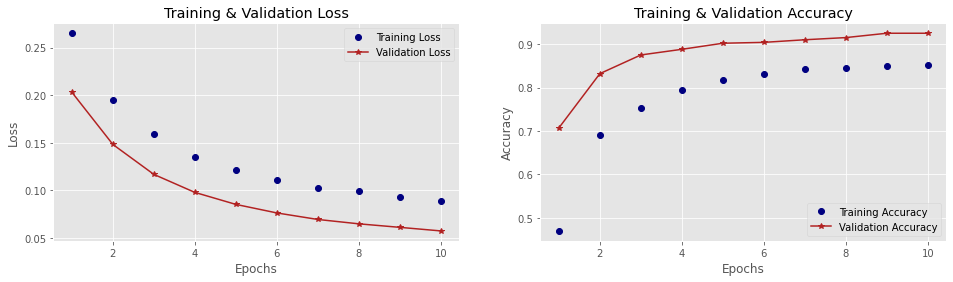

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

#Function to plot Graphs
def show_plots(history):
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    #Plotting Graph for the Losses
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    #Plot Graph for the Accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    #Delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
    
show_plots(history.history)

Grafica de confusion de la matrix

In [ ]:
#Getting test labels and predictions
preds = np.round(model.predict(x_test),0)  
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
#Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Normalize the values
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion matrix')
    
    #Plot the matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    #Going over all ten categories, and for each category going over all 
    #ten categories to get a square matrix for every category 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix


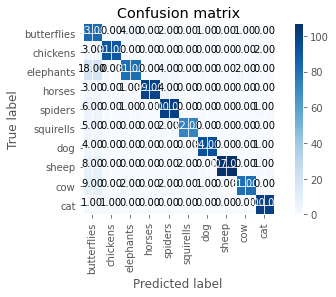

In [ ]:
#Call plotting function
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders',
                       'squirells', 'dog', 'sheep', 'cow', 'cat'])

Testeo con imagenes

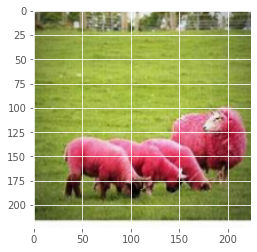

Actual  : sheep
Predict : cat


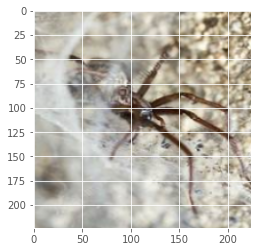

Actual  : spider
Predict : cat


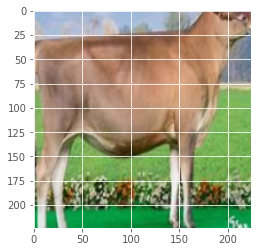

Actual  : cow
Predict : cat


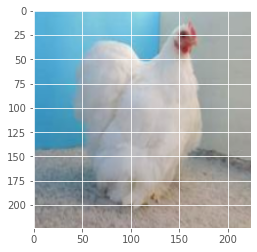

Actual  : chicken
Predict : cat


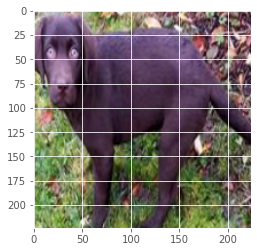

Actual  : dog
Predict : squirrel


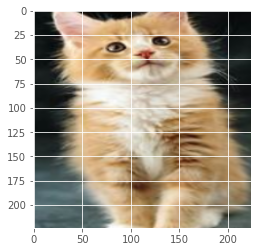

Actual  : cat
Predict : cat


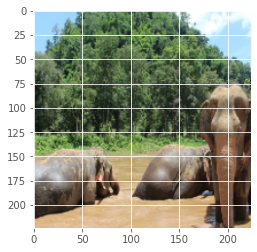

Actual  : elephant
Predict : cat


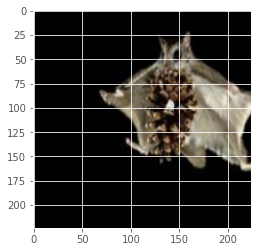

Actual  : squirrel
Predict : dog


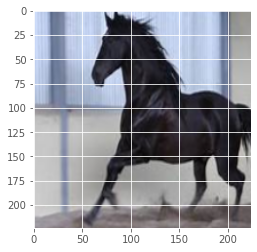

Actual  : horse
Predict : cat


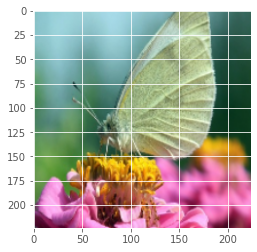

Actual  : butterfly
Predict : cat


In [ ]:
#Empty list to get images for testing
test_images = []
j = 76

#Getting one image from each category for testing
for i in range(10):
    #Getting File Path
    path = train_df[train_df.category == i].values[j]
    #Getting Image from File
    a = images[train_df[train_df.filename == path[0]].index[0]]
    #Converting image into pixel array
    img = np.array(a)
    
    #Preprocessing images using opencv
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = centering_image(cv2.resize(img, dsize=(256, 256)))
    
    #Reshaping into 224x224psx for VGG-16 model 
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)

#Making predictions on test_images
predictions = model.predict(test_images)
animals = name_animal

#Plotting predictions
i = 0
for pred in predictions:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1
